# Model to predict a tip

To suggest a tip amount to the rider I produced a model based on the NY yellow taxi data.
- This data can be found here: (http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) and is described by the data dictionary at (http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

## Data preparation 

In [1]:
from scipy import stats
from scipy.stats import lognorm, spearmanr, linregress
import random
import pandas as pd
import numpy as np
import datetime as dt
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
import pysal as ps
from pylab import figure, scatter, show
import math
import statsmodels.api as sm 
from scipy.interpolate import interp1d
from sklearn.externals import joblib
import requests, json
import pickle
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

C:\Users\hyelim\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [2]:
allFiles = glob.glob("*.csv")
frame = pd.DataFrame()
list_ = []

for file_ in allFiles:
    num_lines = sum(1 for l in open(file_))
    # Sample size - in this case ~1%
    size = int(num_lines / 100)

    skip_idx = random.sample(range(1, num_lines), num_lines - size)

    df = pd.read_csv(file_, skiprows=skip_idx, index_col=None, header=0 )
    list_.append(df)
    
yellow = pd.concat(list_)

* The data for the months of March, June, and November in 2017 for Yellow Taxi is imported into the "yellow" variable.
 - Total data dimensions: 29236424 rows * 17 columns
     - So, I chose only 1% of data to facilitate to see the data before make a model.
 - There is an unusual value in the passenger_count like 192.
 - There are negative values in fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge and total_amount.
 - In RatecodeID there are inappropriate values like 99.

- Accordig to the Data Dictionary – Yellow Taxi Trip Records (http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf):
 - VendorID: TPEP provider that provided the record 
         (1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.)
 - tpep_pickup_datetime / tpep_dropoff_datetime: The date and time when the meter was engaged or disengaged.
 - Passenger_count: The number of passengers in the vehicle and This is a driver-entered value.
 - Trip_distance: The elapsed trip distance in miles reported by the taximeter.
 - PULocationID / DOLocationID: PULocationID TLC Taxi Zone in which the taximeter was engaged or disengaged.
 - RateCodeID: RateCodeID The final rate code in effect at the end of the trip.
         (1= Standard rate; 2=JFK; 3=Newark; 4=Nassau or Westchester; 5=Negotiated fare; 6=Group ride)
 - Store_and_fwd_flag: whether the trip record was held in vehicle memory before sending to the vendor.
         (Y= store and forward trip = the vehicle did not have a connection to the server; N= not a store and forward trip)
 - Payment_type: how the passenger paid for the trip. 
         (1= Credit card; 2= Cash; 3= No charge; 4= Dispute; 5= Unknown; 6= Voided trip)
 - Fare_amount: The time-and-distance fare calculated by the meter.
 - Extra: the 0.5 dollar and 1 dollar rush hour and overnight charges.
 - MTA_tax: 0.5 dollar MTA tax that is automatically triggered based on the metered rate in use.
 - Improvement_surcharge: 0.3 dollar improvement surcharge assessed trips at the flag drop.
 - Tip_amount: This field is automatically populated for credit card tips. Cash tips are not included.
 - Tolls_amount: Total amount of all tolls paid in trip. 
 - Total_amount: The total amount charged to passengers. Does not include cash tips.

## Data Cleaning

In [4]:
data = yellow[(yellow['passenger_count'] < 10) & 
                        (yellow['passenger_count'] > 0) & 
                        (yellow['extra'] >= 0) &
                        (yellow['extra'] <= 1) &
                        (yellow['RatecodeID'] < 7) &
                        (yellow['mta_tax'] >= 0) &
                        (yellow['trip_distance'] > 0) &
                        (yellow['tip_amount'] >= 0) &
                        (yellow['tolls_amount'] >= 0) &
                        (yellow['improvement_surcharge'] > 0) &
                        (yellow['total_amount'] > 0)]

data = data.replace({'store_and_fwd_flag': {'Y': 1, 'N': 0}})

data['tpep_pickup_datetime'] = data.tpep_pickup_datetime.apply(lambda x:
                                                               dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['tpep_dropoff_datetime'] = data.tpep_dropoff_datetime.apply(lambda x:
                                                                 dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

data['pickup_hour'] = data.tpep_pickup_datetime.apply(lambda x: x.hour)
data['pickup_day'] = data.tpep_pickup_datetime.apply(lambda x: x.weekday())
data = data.assign(duration = lambda x: 
                   ((x.tpep_dropoff_datetime-x.tpep_pickup_datetime)/ np.timedelta64(1, 'm')))


## Distribution of variables

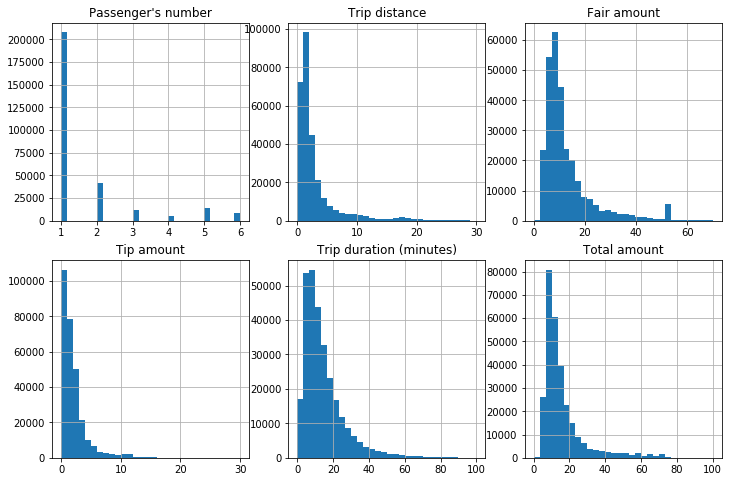

In [5]:
fig,ax = plt.subplots(2,3,figsize=(12,8))

data.passenger_count.hist(bins=30, ax=ax[0,0])
data.trip_distance.hist(bins=30, ax=ax[0,1], range = (0,30))
data.fare_amount.hist(bins=30, ax=ax[0,2], range = (0,70))
data.tip_amount.hist(bins=30, ax=ax[1,0], range = (0,30))
data.duration.hist(bins=30, ax=ax[1,1], range = (0,100))
data.total_amount.hist(bins=30, ax=ax[1,2], range = (0,100))


ax[0,0].set_title("Passenger's number")
ax[0,1].set_title('Trip distance')
ax[0,2].set_title("Fair amount")
ax[1,0].set_title("Tip amount")
ax[1,1].set_title("Trip duration (minutes)")
ax[1,2].set_title("Total amount")


plt.show()

- Most trips have a single passenger.
- The distribution of trip distance, fair amount, tip amount, trip duration and total amount look similar to a logistic distribution.

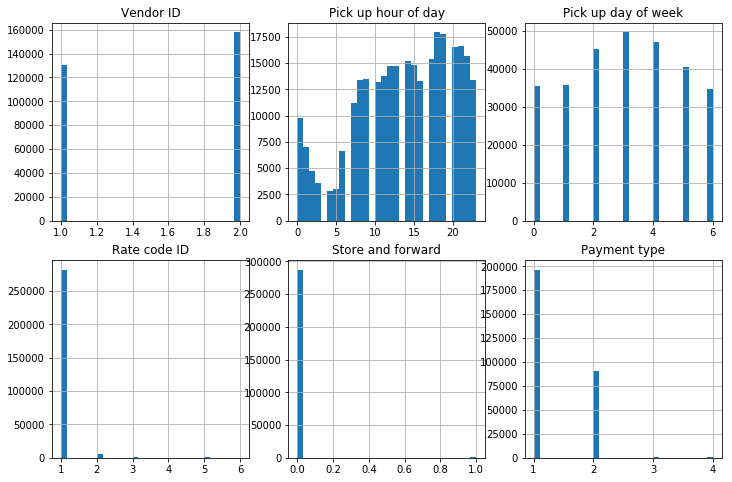

In [6]:
fig,ax = plt.subplots(2,3,figsize=(12,8))

data.VendorID.hist(bins=30, ax=ax[0,0])
data.pickup_hour.hist(bins=30, ax=ax[0,1])
data.pickup_day.hist(bins=30, ax=ax[0,2])
data.RatecodeID.hist(bins=30, ax=ax[1,0])
data.store_and_fwd_flag.hist(bins=30, ax=ax[1,1])
data.payment_type.hist(bins=30, ax=ax[1,2])



ax[0,0].set_title("Vendor ID")
ax[0,1].set_title("Pick up hour of day")
ax[0,2].set_title("Pick up day of week")
ax[1,0].set_title("Rate code ID")
ax[1,1].set_title("Store and forward")
ax[1,2].set_title("Payment type")

plt.show()

- The VeriFone Inc. has somewhat higher occupancy than CMT.
- Most trips are charged with a standard rate.
- Most trip records are related to 'connection to the server'.
- A credit card is the most used payment method, followed by cash payment.

The tip amount data is only based on credit card payments. When trips are paid by any other means we can't see how much was tipped, so the data reads 0. So, these zero data are not useful for this analysis. Also, I made a new column ("before_tip") that indicated the amount of a trip cost to a rider before tipping.

In [6]:
tip_data = data[(data['payment_type'] == 1) & (data['store_and_fwd_flag'] == 0)]
tip_data = tip_data.drop(['payment_type'], axis=1)
tip_data = tip_data.assign(before_tip = lambda x: (x.total_amount-x.tip_amount))

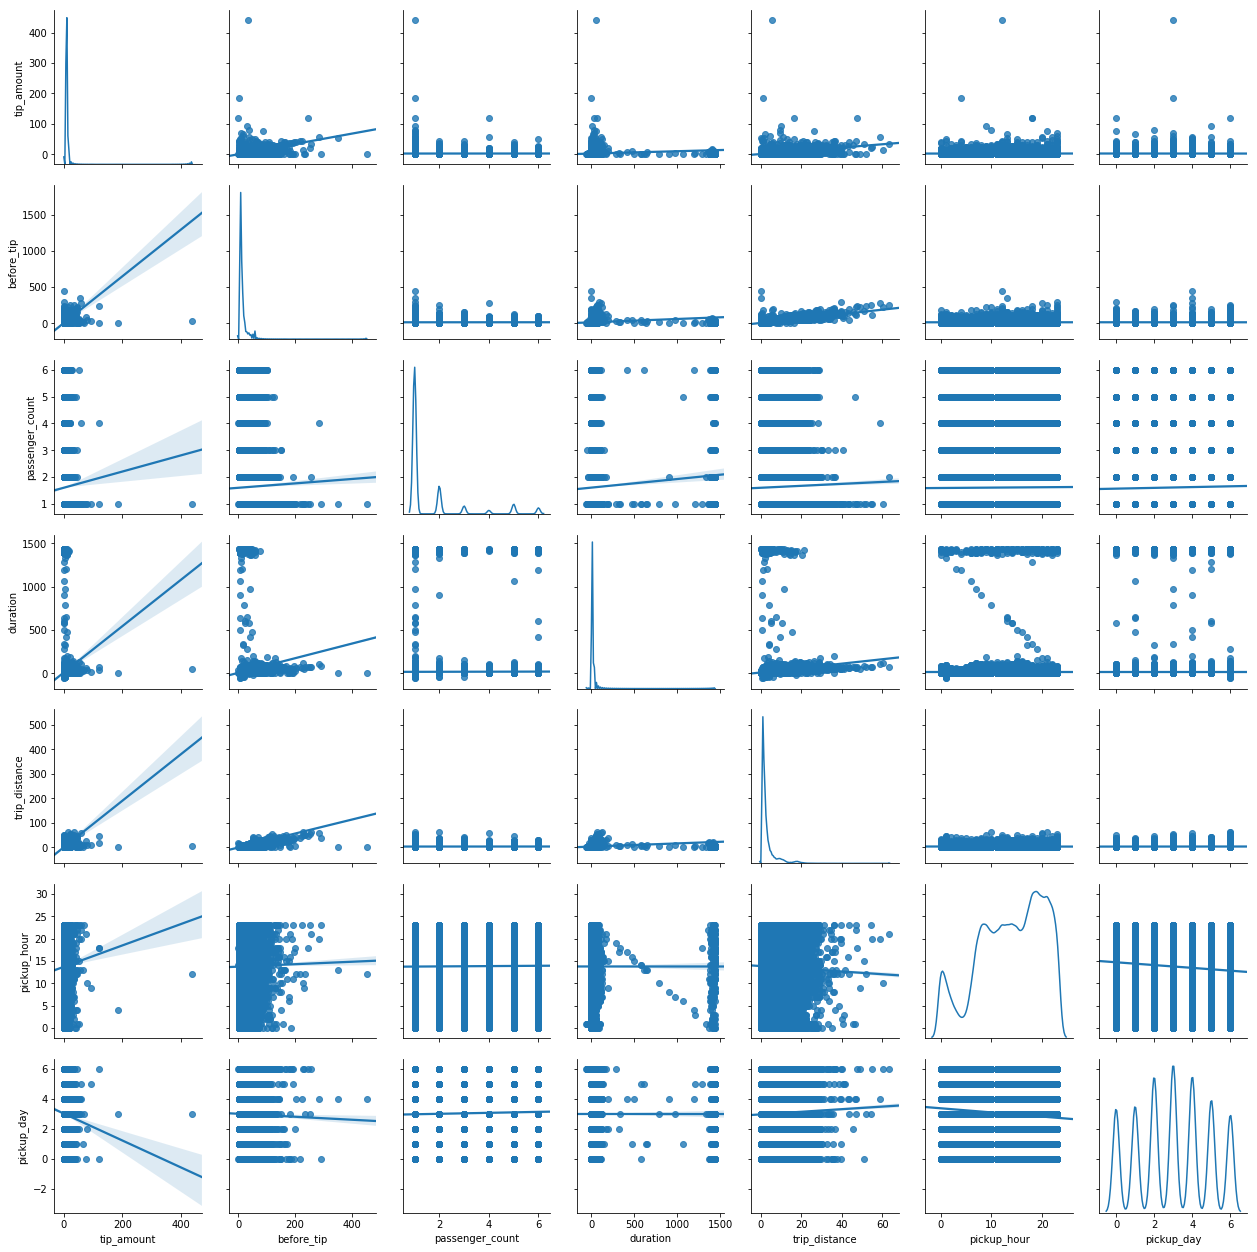

In [10]:
sns.pairplot(tip_data, 
             vars=['tip_amount','before_tip','passenger_count','duration',
                   'trip_distance','pickup_hour','pickup_day'], 
             diag_kind="kde", kind="reg")

plt.show()

- Tip amount has a relation with the total amount before tip. 

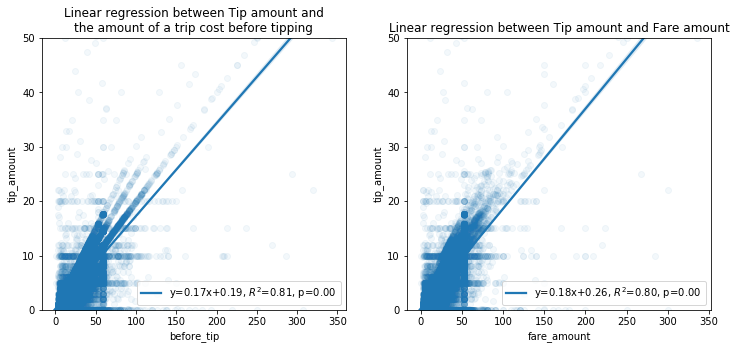

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
slope, intercept, r_value, p_value, std_err = stats.linregress(tip_data['before_tip'],
                                                               tip_data['tip_amount'])

ax = sns.regplot(x="before_tip", y="tip_amount", data=tip_data,
 line_kws={'label':"y={0:.2f}x+{1:.2f}, $R^2$={2:.2f}, p={3:.2f} ".format(slope,
                                                                          intercept,
                                                                          r_value,p_value)},
                scatter_kws={'alpha':0.05})
ax.legend()
ax.axes.set_ylim(0,50)
ax.set_title("""Linear regression between Tip amount and
the amount of a trip cost before tipping""")

plt.subplot(1,2,2)
slope, intercept, r_value, p_value, std_err = stats.linregress(tip_data['fare_amount'],
                                                               tip_data['tip_amount'])

ax = sns.regplot(x="fare_amount", y="tip_amount", data=tip_data,  
 line_kws={'label':"y={0:.2f}x+{1:.2f}, $R^2$={2:.2f}, p={3:.2f} ".format(slope,
                                                                          intercept,
                                                                          r_value,p_value)},
                scatter_kws={'alpha':0.05})
ax.legend()
ax.axes.set_ylim(0,50)
ax.set_title("Linear regression between Tip amount and Fare amount")
plt.show()
plt.show()

As seen in the above plots, a tip amount is highly related to a fair amount and to the whole fare before tipping. Curiously, it looks like passengers tip more at more expensive trips. So, I added new columns for the 'tip_percentage'.
- tip_percentage_1: aa a proportion of a fare amount
- tip_percentage_2: as a proportion of the whole amount before tipping

Also, I made a new column to indicate which trip had had a tip. (0: no tipping; 1: paid a tip)

In [8]:
tip_data = tip_data.assign(tip_percentage_1 = lambda x: (x.tip_amount/x.fare_amount)*100)
tip_data = tip_data.assign(tip_percentage_2 = lambda x: (x.tip_amount/(x.before_tip))*100)

In [9]:
tip_data['tip_no_paid'] = tip_data.tip_amount.isin([0]).astype(np.int64)

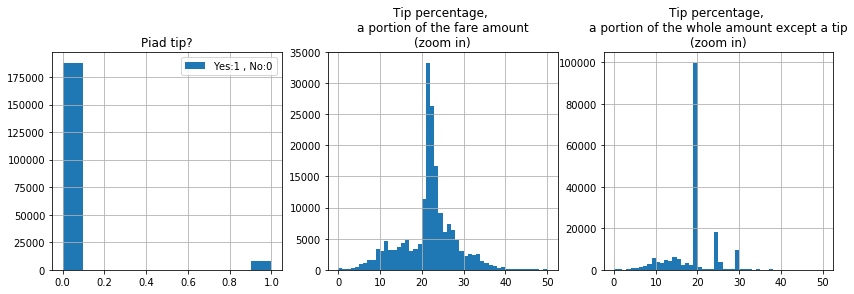

In [18]:
fig,ax = plt.subplots(1,3,figsize=(14,4))
tip_data.tip_no_paid.hist(ax=ax[0])
tip_data.tip_percentage_1[(tip_data['tip_percentage_1'] <=50)&
                          (tip_data['tip_no_paid'] == 0)].hist(bins=50,ax=ax[1])

tip_data.tip_percentage_2[(tip_data['tip_percentage_2'] <=50)&
                          (tip_data['tip_no_paid'] == 0)].hist(bins=50,ax=ax[2])

ax[0].set_title("Piad tip?")
ax[0].legend(['Yes:1 , No:0'])
ax[1].set_title("""Tip percentage, 
a portion of the fare amount
(zoom in)""")

ax[2].set_title("""Tip percentage, a portion of 
the amount of a trip cost before tipping
(zoom in)""")

plt.show()

Most passengers tipped. The distribution of tip percentage that was calculated by a portion of the fare amount seems a unimodal concentrated distribution. 
However when calculated a tip percentage by a portion of the total amount pay beforet tipping, we can see three picks, 20%, 25% and 30%.

- It looks like many passengers seem to make a default choice among the three options before tipping.
- According to [this video](https://www.youtube.com/watch?v=qdTtbc2-zeU) there are usually options to pay a tip. In this case there are three buttons. So, depanding on the programe that is representing to passenger choose a tip, the distribution of tip percentage and tip amount would be changed dramatically --e.g. if the screen offered a blank option to pay a tip, or only two options.
- Most passengers tip by selecting among these three options. I think that this way it's easy to tip. If someone wouldn't want to tip they should push the other button and put a tip amount on purpose. As generally people look for a taxi when they do not have time (personal hypothesis), selecting among the options to pay a tip looks the easiest option. 

In [10]:
tip_select = tip_data[(tip_data['tip_no_paid'] == 0)]

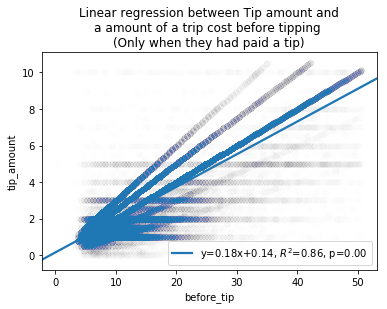

In [8]:
tip_select_ = tip_select[(np.abs(stats.zscore(tip_select[['tip_amount',
                                                          'before_tip']]))<3).all(axis=1)]


slope, intercept, r_value, p_value, std_err = stats.linregress(tip_select_['before_tip'],
                                                               tip_select_['tip_amount'])

ax = sns.regplot(x="before_tip", y="tip_amount", data=tip_select_, 
                 line_kws={'label':"y={0:.2f}x+{1:.2f}, $R^2$={2:.2f}, p={3:.2f} ".format(slope,
                                                                                          intercept,
                                                                                          r_value,p_value)},
                scatter_kws={'alpha':0.005})
ax.legend()
ax.set_title("""Linear regression between Tip amount and
a amount of a trip cost before tipping 
(Only when they had paid a tip)""")

plt.show()

When we focus on when passengers had paid a tip, they paid about 18% of the whole amount before tipping. In the above graph we could observe three diagonal lines (20, 25, 30%) and these lines indicate a tendency of tip percentage.Also, there are various horizontal lines.

So, what's different after eliminating the effect of the defalt options (20, 25, 30%)? 
I made a new variable "tip_decision" to see how much pay a tip when passengers would be going to pay a tip but not just select among these three options.

In [11]:
tip_decision = tip_data[(tip_data['tip_no_paid'] == 0)^
                        ((tip_data['tip_percentage_2'].round() ==20)|
                         (tip_data['tip_percentage_2'].round() ==25)|
                         (tip_data['tip_percentage_2'].round() ==30))]

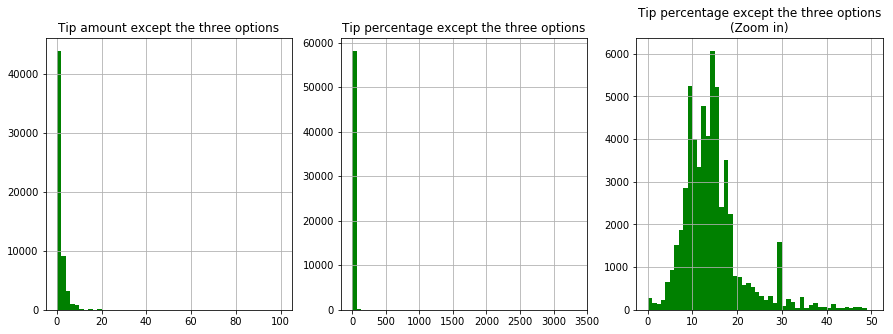

In [13]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

tip_decision.tip_percentage_2.hist(bins=50, ax=ax[1],color='g')
tip_decision.tip_amount.hist(bins=50, ax=ax[0],color='g')
tip_decision.tip_percentage_2[tip_decision['tip_percentage_2'] < 50].hist(bins=50, 
                                                                          ax=ax[2],
                                                                          color='g')

ax[1].set_title("Tip percentage except the three options")
ax[2].set_title("""Tip percentage except the three options
(Zoom in)""")
ax[0].set_title("Tip amount except the three options")

plt.show()

- After eliminate the three defalt options there is a slice tendency to select a tip amount like 15%, 10% or 18%.

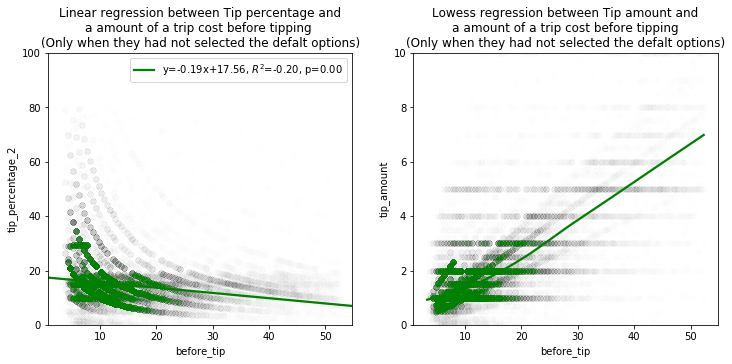

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)

tip_decision_ = tip_decision[(np.abs(stats.zscore(tip_decision[['tip_percentage_2',
                                                                'before_tip']]))<3).all(axis=1)]


slope, intercept, r_value, p_value, std_err = stats.linregress(tip_decision_['before_tip'],
                                                               tip_decision_['tip_percentage_2'])

ax = sns.regplot(x="before_tip", y="tip_percentage_2", data=tip_decision_, color='g',
                 line_kws={'label':"y={0:.2f}x+{1:.2f}, $R^2$={2:.2f}, p={3:.2f} ".format(slope,
                                                                                          intercept,
                                                                                          r_value,p_value)},
                scatter_kws={'alpha':0.005})
ax.legend()
ax.axes.set_ylim(0,100)
ax.set_title("""Linear regression between Tip percentage and
a amount of a trip cost before tipping 
(Only when they had not selected the defalt options)""")

plt.subplot(1,2,2)

ax = sns.regplot(x="before_tip", y="tip_amount", data=tip_decision_,  lowess=True,color='g',
                scatter_kws={'alpha':0.005})
ax.axes.set_ylim(0,10)
ax.set_title("""Lowess regression between Tip amount and
a amount of a trip cost before tipping
(Only when they had not selected the defalt options)""")

plt.show()

- After eliminate the three default options, a tip percentage has a negative relationship with whole amount cost before tipping. 
- A passenger who tipped but did not select among the three options (20, 25, 30%) generally paid more of a tip as the whole amount increased. Although some pessengers payed a huge tip, generally they'd like to pay under 25 dollars.

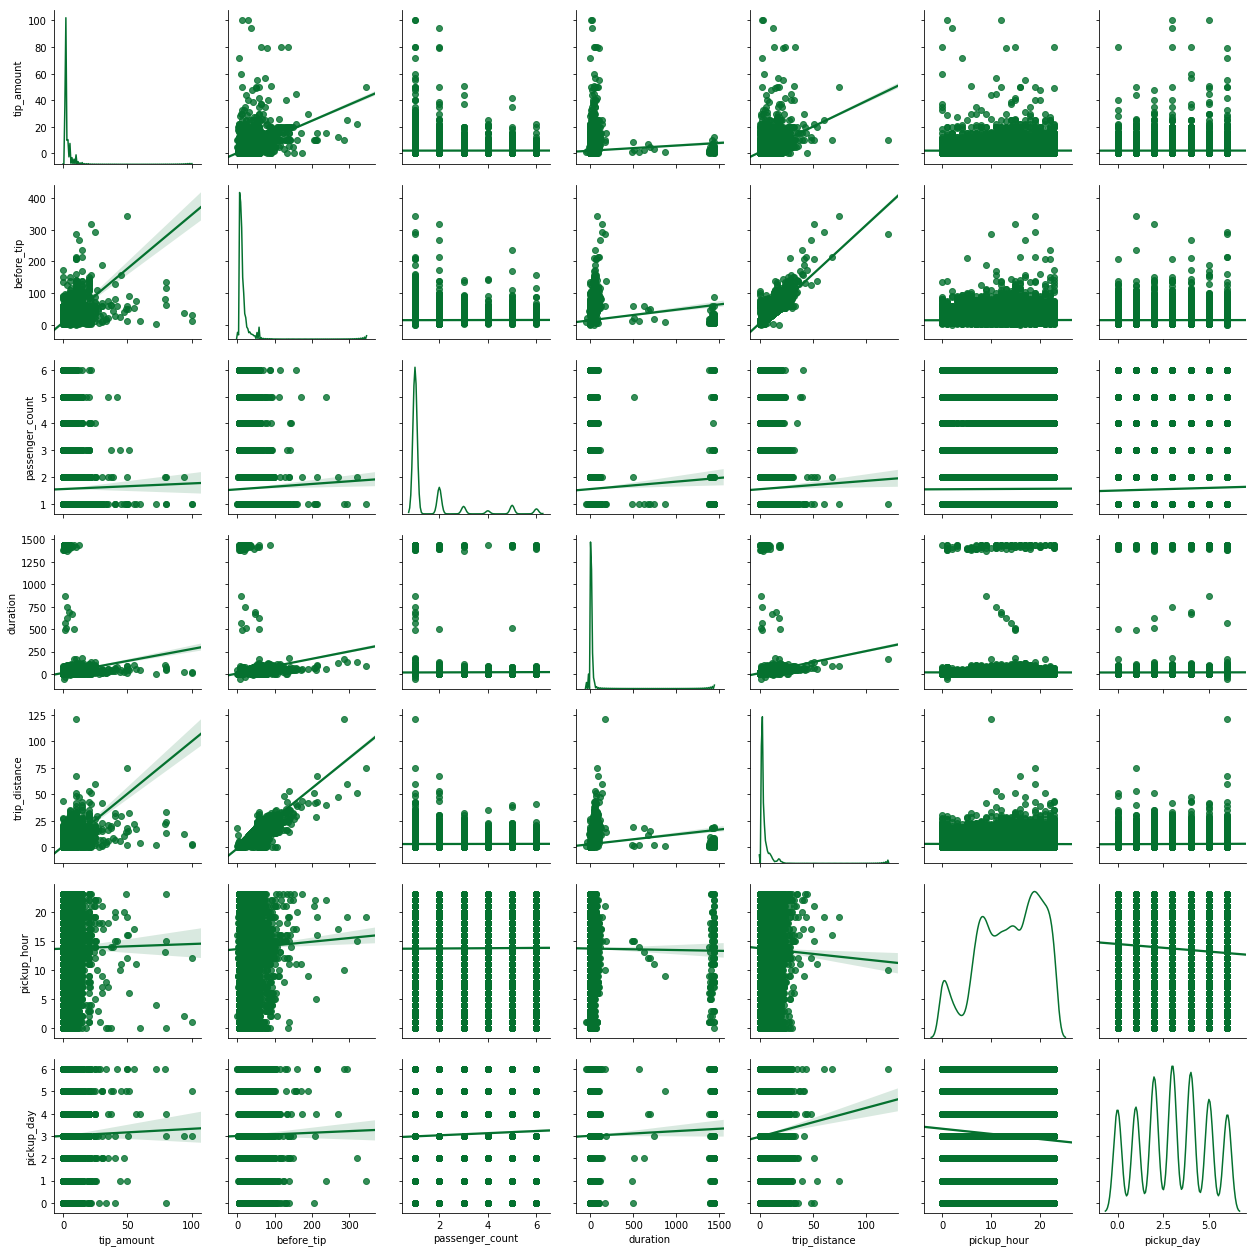

In [23]:
sns.pairplot(tip_decision, 
             vars=['tip_amount','before_tip','passenger_count','duration',
                   'trip_distance','pickup_hour','pickup_day'], 
             diag_kind="kde", kind="reg")
sns.set_palette("BuGn")
plt.show()


- When the three defalt options (20, 25, 30%) were eliminated there is a relationship between tip ampiunt and the other variable - before trip: a whole amount before pay a tip, trip distance and trip duration -.  

## Applied ML with Linear Regression

Until now, I treated only 1% of data. So, I will going to make a linear model to suggest a tip amount using all data.

### Import data

In [2]:
allFiles = glob.glob("*.csv")
frame = pd.DataFrame()
list_ = []

for file_ in allFiles:
    num_lines = sum(1 for l in open(file_))

    df = pd.read_csv(file_, header=0)
    list_.append(df)
    
df = pd.concat(list_)

In [3]:
df_clean = df[(df['passenger_count'] < 10) & 
                        (df['passenger_count'] > 0) & 
                        (df['extra'] >= 0) &
                        (df['extra'] <= 1) &
                        (df['RatecodeID'] < 7) &
                        (df['mta_tax'] >= 0) &
                        (df['trip_distance'] > 0) &
                        (df['tip_amount'] >= 0) &
                        (df['tolls_amount'] >= 0) &
                        (df['improvement_surcharge'] > 0) &
                        (df['total_amount'] > 0)]

df_clean['tpep_pickup_datetime'] = df_clean.tpep_pickup_datetime.apply(
                                    lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
df_clean['tpep_dropoff_datetime'] = df_clean.tpep_dropoff_datetime.apply(
                                    lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

df_clean['pickup_hour'] = df_clean.tpep_pickup_datetime.apply(lambda x: x.hour)
df_clean['pickup_day'] = df_clean.tpep_pickup_datetime.apply(lambda x: x.weekday())

df_clean = df_clean.assign(trip_duration = lambda x: 
                           ((x.tpep_dropoff_datetime-x.tpep_pickup_datetime)/ np.timedelta64(1, 'm')))

df_clean = df_clean.assign(before_tip = lambda x: (x.total_amount-x.tip_amount))

In [4]:
df_clean = df_clean[(df_clean['payment_type'] == 1)] # only credit card payment

In [5]:
def ML_LR(new_df):
    features = new_df.loc[:,new_df.columns != 'tip_amount']
    targets = new_df.loc[:,new_df.columns == 'tip_amount']
    X_train, X_test, y_train, y_test = train_test_split(features,targets, 
                                                    test_size=0.1, 
                                                    random_state=42)
    reg_model = LinearRegression()
    reg_model.fit(X_train, y_train)
    print('Intercept :', reg_model.intercept_[0], '\n')
    print(pd.DataFrame({'features':X_train.columns,'coeficients':reg_model.coef_[0]}))
    print("Training set score: {:.2f}".format(reg_model.score(X_train, y_train)))

    cv_reg_model = LinearRegression()
    cv_scores = cross_val_score(cv_reg_model, features, targets,cv=100, scoring='r2')

    print("\nAverage 100-Fold CV Score: {}".format(np.mean(cv_scores)))

    y_pred = reg_model.predict(X_test)

    y_pred_a = pd.DataFrame(y_pred)
    y_test_a = y_test.reset_index(drop=True, inplace=False)
    pred_act_df = pd.concat([y_test_a,y_pred_a], axis=1).sort_values(1,axis=1).reset_index(drop=True)

    plt.figure(figsize=(6, 6))
    maxlimit = pred_act_df['tip_amount'].max()

    plt.scatter(pred_act_df[0], pred_act_df['tip_amount'], s=10, alpha=0.1)
    plt.xlabel('Predicted Tip amount')
    plt.ylabel('Actual Tip amount')
    plt.plot([-1,maxlimit], [-1,maxlimit], ls="--", c=".3")
    plt.title('Actual vs Predicted Tip amount')
    plt.show()

    #for calculating MSE
    y_pred_test = reg_model.predict(X_test)
    y_pred_train = reg_model.predict(X_train)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    print("Root Mean Squared Error of Training Set: {}".format(rmse_train))
    print("Root Mean Squared Error of Testing Set: {}".format(rmse_test))

    X_train_sm = sm.add_constant(X_train)
    sm_train_model = sm.OLS(y_train, X_train_sm).fit()
    print('Training set adj r2: {}'.format(sm_train_model.rsquared_adj))

    #run CV again and loop through results applying adjusted r2 formula. Output the results
    cv_scores_r2 = cross_val_score(cv_reg_model, features, targets,cv=10, scoring='r2')
    cv_scores_adj = []
    n = len(features)
    k = len(features.columns)
    for r in cv_scores_r2:
        adj_r2 = 1-(((1-r)*(n-1))/(n-k-1))
        cv_scores_adj.append(adj_r2)
    print('Average 10-Fold CV adj r2: {}'.format(np.mean(cv_scores_adj)))
    
    X_train_sm = sm.add_constant(X_train)
    sm_model = sm.OLS(y_train, X_train_sm).fit()
    print(sm_model.summary())
    print(sm_model.rsquared_adj)

    result = pd.DataFrame({'features':[X_train.columns.values],'coeficients':[reg_model.coef_], 'rsquared_adj': sm_model.rsquared_adj,
             'AIC': sm_model.aic})
    
    #calculate the residuals
    y_pred = pd.DataFrame(y_pred)
    y_test = y_test.reset_index(drop=True)
    residuals = y_test.tip_amount - y_pred[0]

    plt.figure(figsize=(9, 3))
    plt.subplot(1,2,1)
    plt.axhline(0, color="blue")
    plt.title('Plot of Residuals')
    plt.scatter(residuals.index,residuals, s=20, alpha=0.01)

    plt.subplot(1,2,2)
    plt.title('Probability Plot')
    stats.probplot(residuals, dist='norm',plot=plt)
    plt.show()
    
    return result

In [6]:
sdf = df_clean[['tip_amount','before_tip','trip_distance','trip_duration']]

sdf['log_tip_amount'] = sdf.tip_amount.apply(np.log)
sdf['log_before_tip'] = sdf.before_tip.apply(np.log)
sdf['log_trip_distance'] = sdf.trip_distance.apply(np.log)
sdf['log_trip_duration'] = sdf.trip_duration.apply(np.log)


new_df = sdf

new_df = new_df.replace([np.inf, -np.inf], np.nan).dropna()
new_df = new_df[(np.abs(stats.zscore(new_df[['tip_amount','log_before_tip',
                                             'log_trip_distance','log_trip_duration']]))<3).all(axis=1)]

#### Using a log transformed *total amounts before tipping*

Intercept : -4.290472371401344 

         features  coeficients
0  log_before_tip     2.797256
Training set score: 0.68

Average 100-Fold CV Score: 0.6758071371678359


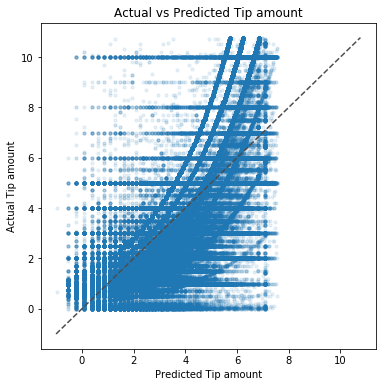

Root Mean Squared Error of Training Set: 1.0272196966573173
Root Mean Squared Error of Testing Set: 1.0262726584890045
Training set adj r2: 0.6780208609927355
Average 10-Fold CV adj r2: 0.6776388976164044
                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                 3.478e+07
Date:                Wed, 12 Sep 2018   Prob (F-statistic):               0.00
Time:                        11:54:47   Log-Likelihood:            -2.3876e+07
No. Observations:            16514398   AIC:                         4.775e+07
Df Residuals:                16514396   BIC:                         4.775e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
     

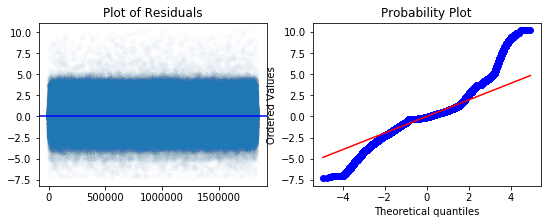

In [7]:
new_df_ = new_df[['tip_amount','log_before_tip']]
m1 = ML_LR(new_df_)

- The equation of this linear model to predict a "tip amount":

                tip amount = - 4.29  + 2.79 log(*whole amount before tipping*) 


- This model could be close the data about 67%.

#### Using log transformed of *total amounts before tipping* and trip distances 


Intercept : -4.801318095442481 

            features  coeficients
0     log_before_tip     3.047674
1  log_trip_distance    -0.170999
Training set score: 0.68

Average 100-Fold CV Score: 0.6765738168718269


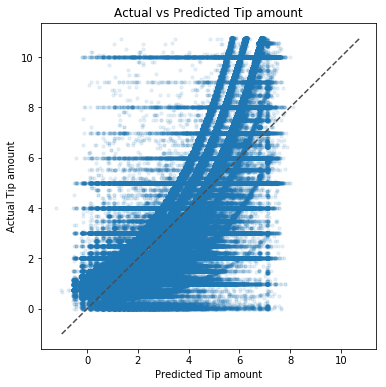

Root Mean Squared Error of Training Set: 1.02601710399195
Root Mean Squared Error of Testing Set: 1.0250851107756958
Training set adj r2: 0.6787742988475064
Average 10-Fold CV adj r2: 0.6783757325312554
                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                 1.745e+07
Date:                Wed, 12 Sep 2018   Prob (F-statistic):               0.00
Time:                        12:02:16   Log-Likelihood:            -2.3857e+07
No. Observations:            16514398   AIC:                         4.771e+07
Df Residuals:                16514395   BIC:                         4.771e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
       

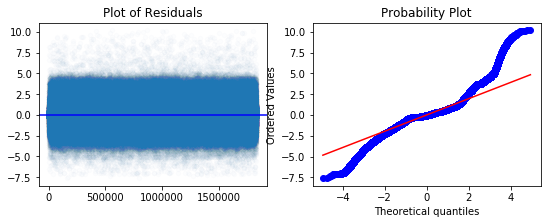

In [8]:
new_df_ = new_df[['tip_amount','log_before_tip','log_trip_distance']]
m2 = ML_LR(new_df_)

- The equation of this linear model to predict a "tip amount":

                tip amount = - 4.80  + 3.04 log(*whole amount before tipping*) - 0.17 log(trip distance)


- This model could be close the data about 67%. Log transformed trip distance information does not have an effect on the prediction model but was a significant.

#### All input variables were log-transformed

Intercept : -6.835504359958915 

            features  coeficients
0     log_before_tip     5.319220
1  log_trip_distance    -0.604091
2  log_trip_duration    -1.351627
Training set score: 0.71

Average 100-Fold CV Score: 0.711241110339651


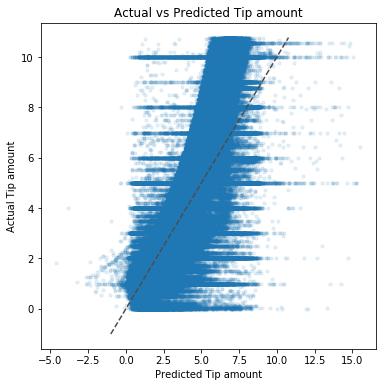

Root Mean Squared Error of Training Set: 0.9693882398583427
Root Mean Squared Error of Testing Set: 0.9686634845121932
Training set adj r2: 0.713254504488583
Average 10-Fold CV adj r2: 0.7129132869926852
                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                 1.369e+07
Date:                Wed, 12 Sep 2018   Prob (F-statistic):               0.00
Time:                        12:10:54   Log-Likelihood:            -2.2919e+07
No. Observations:            16514398   AIC:                         4.584e+07
Df Residuals:                16514394   BIC:                         4.584e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
      

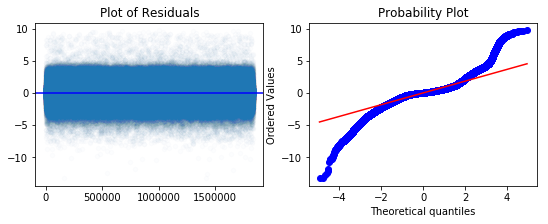

In [9]:
new_df_ = new_df[['tip_amount','log_before_tip','log_trip_distance', 'log_trip_duration']]
m3 = ML_LR(new_df_)

- The equation of this linear model to predict a "tip amount":

                tip amount = - 6.83  + 5.31 log(*whole amount before tipping*) - 0.6 log(trip distance) - 1.35 log(trip duration)


- This model could be close the data about 71%. The score was incremented.

#### Using only a whole cost before tipping

Intercept : 0.272959831889672 

     features  coeficients
0  before_tip     0.168488
Training set score: 0.74

Average 100-Fold CV Score: 0.739577599545839


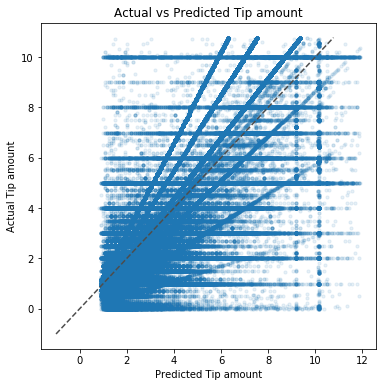

Root Mean Squared Error of Training Set: 0.9205629256829562
Root Mean Squared Error of Testing Set: 0.9188851332986852
Training set adj r2: 0.7414122074279819
Average 10-Fold CV adj r2: 0.7411623722271428
                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                 4.735e+07
Date:                Wed, 12 Sep 2018   Prob (F-statistic):               0.00
Time:                        12:17:10   Log-Likelihood:            -2.2066e+07
No. Observations:            16514398   AIC:                         4.413e+07
Df Residuals:                16514396   BIC:                         4.413e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
     

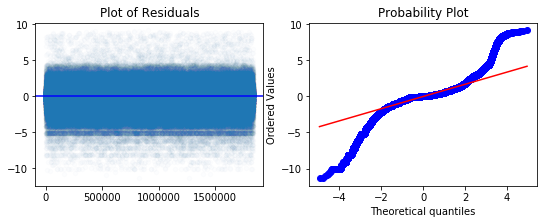

In [10]:
new_df_ = new_df[['tip_amount','before_tip']]
m4 = ML_LR(new_df_)

- The equation of this linear model to predict a "tip amount":

                        tip amount = 0.27  + 0.16 *whole amount before tipping* 


- This model could be close the data about 74%. 

#### Using whole cost before tipping and trip distance

Intercept : 0.21876065364187447 

        features  coeficients
0     before_tip     0.179897
1  trip_distance    -0.037822
Training set score: 0.74

Average 100-Fold CV Score: 0.7399170650355696


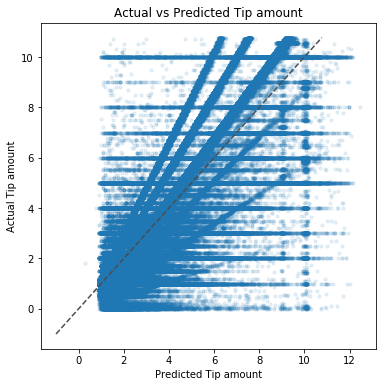

Root Mean Squared Error of Training Set: 0.9199510604003025
Root Mean Squared Error of Testing Set: 0.9182857154272068
Training set adj r2: 0.7417558256832335
Average 10-Fold CV adj r2: 0.7414948007010083
                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                 2.372e+07
Date:                Wed, 12 Sep 2018   Prob (F-statistic):               0.00
Time:                        12:24:06   Log-Likelihood:            -2.2055e+07
No. Observations:            16514398   AIC:                         4.411e+07
Df Residuals:                16514395   BIC:                         4.411e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
     

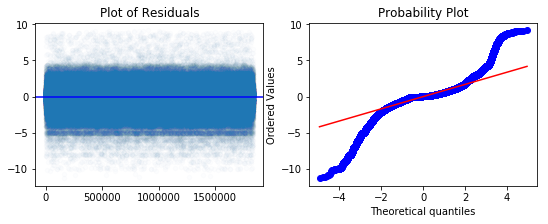

In [11]:
new_df_ = new_df[['tip_amount','before_tip','trip_distance']]
m5 = ML_LR(new_df_)

- The equation of this linear model to predict a "tip amount":

                            tip amount = 0.218  + 0.179 *whole amount before tipping* - 0.03 trip distance 


- This model could be close the data about 74%. 

#### Using the three input variables 

Intercept : 0.2374814120410531 

        features  coeficients
0     before_tip     0.170734
1  trip_distance    -0.022603
2  trip_duration     0.004590
Training set score: 0.74

Average 100-Fold CV Score: 0.740007888997033


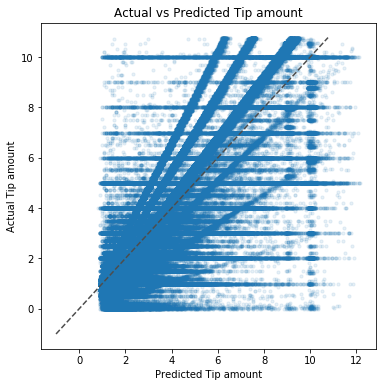

Root Mean Squared Error of Training Set: 0.91979528330182
Root Mean Squared Error of Testing Set: 0.9181323233718413
Training set adj r2: 0.7418432606207517
Average 10-Fold CV adj r2: 0.74158011921998
                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                 1.582e+07
Date:                Wed, 12 Sep 2018   Prob (F-statistic):               0.00
Time:                        12:33:17   Log-Likelihood:            -2.2052e+07
No. Observations:            16514398   AIC:                         4.410e+07
Df Residuals:                16514394   BIC:                         4.410e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
         

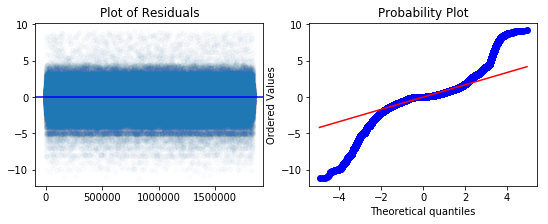

In [12]:
new_df_ = new_df[['tip_amount','before_tip','trip_distance', 'trip_duration']]
m6 = ML_LR(new_df_)

- The equation of this linear model to predict a "tip amount":

                tip amount = - 0.23  + 0.17 *whole amount before tipping* - 0.02 trip distance + 0.005 trip duration


- This model could be close the data about 74%. 

In [13]:
total_m = pd.concat([m1,m2,m3,m4,m5,m6])
total_m.sort_values(by=['AIC'])

,features,coeficients,rsquared_adj,AIC
0,"[before_tip, trip_distance, trip_duration]","[[0.17073406346925854, -0.022603131741174648, ...",0.741843,4.410449e+07
0,"[before_tip, trip_distance]","[[0.17989705492461686, -0.037821569878118064]]",0.741756,4.411009e+07
0,[before_tip],[[0.16848756630871625]],0.741412,4.413204e+07
0,"[log_before_tip, log_trip_distance, log_trip_d...","[[5.319219969041964, -0.6040907271803546, -1.3...",0.713255,4.583897e+07
0,"[log_before_tip, log_trip_distance]","[[3.047674179740816, -0.1709989693014438]]",0.678774,4.771416e+07
0,[log_before_tip],[[2.7972559169859155]],0.678021,4.775285e+07


# Conclusion

- The most passengers on a taxi make a decision choosing among the three tipping options: 20%, 25, 30%.
- That means depending on the how to present options to a rider (only two options: 25% and 30%; different three options: 15%, 20%, 25%; no defalt option just blank for putting a tip amount (dollar) or a tip percentage (%); etc.) that would be make a different data distribution. In order to see these matters A/B test is needed.
- Since variables have a skewed distribution I tried a log-transformation but the variance of the model was not decreased. 
- Using three variables (whole amount before tipping, trip distance, trip duration) the model's score was a little bit higher than it with a total cost before tipping alone, but the complexity also would be increased. So, using the whole amount before tipping variable is sufficient.




# Run Model API

### Generate Linear Regression Model


In [7]:
ML_df = new_df[['tip_amount','before_tip']]

features = ML_df.loc[:,ML_df.columns != 'tip_amount']
targets = ML_df.loc[:,ML_df.columns == 'tip_amount']
X_train, X_test, y_train, y_test = train_test_split(features,targets, 
                                                    test_size=0.1, 
                                                    random_state=42)
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

tip_amount_pred = reg_model.predict(X_train)

In [8]:
train_set, test_set = train_test_split(ML_df, test_size=0.1, random_state=42)

df_copy = train_set.copy()

test_set_full = test_set.copy()
test_set = test_set.drop(["tip_amount"], axis=1)

train_labels = df_copy['tip_amount']

train_set_full = train_set.copy()
train_set = train_set.drop(["tip_amount"], axis=1)

reg_model = LinearRegression()

reg_model.fit(train_set, train_labels)

tip_pred = reg_model.predict(test_set)


### Run "api.py"

### Persist Model and Data

In [50]:
with open("linear_regression_model.pkl", "wb") as file_handler:
    pickle.dump(reg_model, file_handler)
    
with open("linear_regression_model.pkl", "rb") as file_handler:
    loaded_pickle = pickle.load(file_handler)
    
loaded_pickle

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [51]:
BASE_URL = "http://127.0.0.1:5000"

joblib.dump(reg_model, "linear_regression_model.pkl")

joblib.dump(train_set, "training_data.pkl")
joblib.dump(train_labels, "training_labels.pkl")

['training_labels.pkl']

### Current Details API


In [44]:
response = requests.get("{}/currentDetails".format(BASE_URL))

response.json()

{'coefficients': [0.16848756630871625],
 'intercepts': 0.272959831889672,
 'score': 0.741412223086172}

### Predict API


In [38]:
driver_said_to_me = {"before_tip": 8}

response = requests.post("{}/predict".format(BASE_URL), json = driver_said_to_me)

response.json()

[1.620860362359402]

In [28]:
ML_df.query('before_tip > 7 and before_tip <9').describe()

,tip_amount,before_tip
count,3.467465e+06,3.467465e+06
mean,1.594121e+00,8.040176e+00
std,4.882023e-01,5.571289e-01
min,1.000000e-02,7.150000e+00
25%,1.450000e+00,7.300000e+00
50%,1.560000e+00,7.800000e+00
75%,1.760000e+00,8.300000e+00
max,1.070000e+01,8.980000e+00


### Retrain API


In [45]:
newer_data = json.dumps([{"before_tip": 12,"tip_amount": 1}, 
                   {"before_tip": 9.4,"tip_amount": 0}])

newer_data

'[{"before_tip": 12, "tip_amount": 1}, {"before_tip": 9.4, "tip_amount": 0}]'

In [47]:
response = requests.post("{}/retrain".format(BASE_URL), json = newer_data)

response.json()

'Retrained model successfully.'

In [49]:
response = requests.post("{}/predict".format(BASE_URL), json = driver_said_to_me)

response.json()

[1.6208601308536057]